# Evaluating Classification Models Using Expected Value

There are lots of ways to evaluate classification models in machine learning: accuracy, precision, recall, f-score, AUC, and more. These metrics are useful when we want to know how well a classification model is performing at its given task, but they may not be as useful in the real world. The focus for these metrics is typically some variation of true positive rate (TP), true negative rate (TN), false positive rate (FP), and false negative rate (FN). In real world business scenarios, however, these metrics aren't all created equal.

Suppose we're predicting customer response to a marketing campaign using a classification model, and we are attempting to target people that have a high probability of buying our product. What might the costs and benefits associated with the various classification rates be? It really depends on how the campaign is implemented. Let's say we're using an email campaign that costs 0.10 USD per email sent, and that we sell our product for 50 USD. It costs us 20 USD to make our product, so our net profict from selling a product is 30 USD.

Possible Costs and Benefits:
- TP: We send an email for 0.10 USD, the customer buys our product for 30 USD, and we net 29.90 USD.
- TN: We don't send an email and no product is purchased. We net 0 USD.
- FP: We send an email for 0.10 USD, no product is purchased, and our net is -0.10 USD.
- FN: We don't send an email and no product is purchased. We net 0 USD.

*Remember, in our example, for ease of understanding, we assume a prospect can only purchase our product if they were solicited to!*

Marketing campaigns have notoriously low response rates, so we'll try training the model with the imbalanced classes and again by oversampling the minority class. Then we'll compare the results of the two models using the expected value. Of course, we'll have to benchmark these results against some simple marketing schemes as well.

#### About the dataset

**Dataset description**\
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution.

**Dataset summary**\
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:

bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).
The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

**Input variables**:

bank client data:
1 - age (numeric)\
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')\
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)\
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')\
5 - default: has credit in default? (categorical: 'no','yes','unknown')\
6 - housing: has housing loan? (categorical: 'no','yes','unknown')\
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

**related with the last contact of the current campaign**:\
8 - contact: contact communication type (categorical: 'cellular','telephone')\
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')\
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')\
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.\

**other attributes**:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)\
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)\
14 - previous: number of contacts performed before this campaign and for this client (numeric)\
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')\

**social and economic context attributes**\
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)\
17 - cons.price.idx: consumer price index - monthly indicator (numeric)\
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)\
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)\
20 - nr.employed: number of employees - quarterly indicator (numeric)\

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')\

**Source: UCI**
http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### Import libraries

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip --quiet
!pip install catboost --quiet

In [2]:
#hide warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from catboost import CatBoostClassifier

#### Loading data

In [19]:
url = r"https://raw.githubusercontent.com/MarcoCalbucci/DataAnalytics/main/PredictiveModeling/Classification/Examples/BankMarketing_ExpectedValueFramework/bank_marketing_data.csv"
df = pd.read_csv(url, sep=";")

#### Data exploration

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                 Non-Null Count  Dtype 
---  ------                                                                                                                                                                                 --------------  ----- 
 0   ,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y  41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


In [6]:
# Unbalanced
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Data exploration with pandas_profiling

In [8]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

#### Sample dataset

In [9]:
# keep only a fraction of df to reduce calculation time
df = df.sample(frac=0.10)

#### Training classification model with CatBoost



In [10]:
label_column = "y"
feature_columns = df.columns.drop(label_column)

X = df[feature_columns]
y = df[label_column]

y = y.str.replace("yes", "1")
y = y.str.replace("no", "0")
y = pd.to_numeric(y)

categorical_features_indices = list(
    set(np.where(X.dtypes != float)[0]).intersection(
        set(np.where(X.dtypes != int)[0])
    )
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42
)

In [11]:
model_names = []
accuracy = []
recall = []
precision = []
f1 = []
roc_auc = []

catboost_base = CatBoostClassifier(verbose=False, random_state=0)
catboost_base.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)
y_pred = catboost_base.predict(X_test)

model_names.append("Catboost Default")
accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))
f1.append(round(f1_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))


catboost_weighted = CatBoostClassifier(
    verbose=False, random_state=0, auto_class_weights="Balanced"
)
catboost_weighted.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)
y_pred = catboost_weighted.predict(X_test)

model_names.append("Catboost Weighted")
accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))
f1.append(round(f1_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))

#### Model evaluation

In [12]:
result_df = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1,
        "Roc_Auc": roc_auc,
    },
    index=model_names,
)

result_df

,Accuracy,Recall,Precision,F1 Score,Roc_Auc
Catboost Default,0.9142,0.4034,0.5783,0.4752,0.6860
Catboost Weighted,0.8617,0.8908,0.4015,0.5535,0.8747


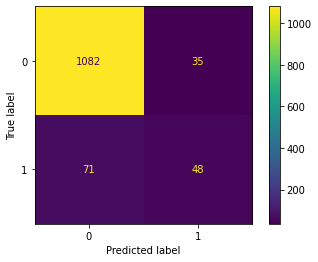

In [13]:
y_pred = catboost_base.predict(X_test)
default_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=default_cm)
disp.plot()

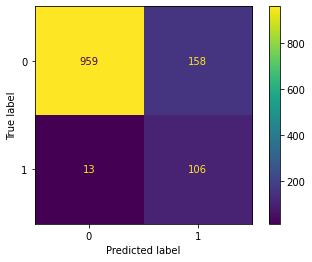

In [14]:
y_pred = catboost_weighted.predict(X_test)
weighted_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=weighted_cm)
disp.plot()

#### Using Expected Profit to Evaluate a Model

The expected profit of a model describes the average profit per person you could expect if you were to use the model. The formula used to calculate it is below.

$\mathrm{expected\:profit} = p(\mathrm{p}) \cdot \Big[ r(\mathrm{TP}) \cdot b(\mathrm{TP}) + r(\mathrm{FN}) \cdot b(\mathrm{FN}) \Big] + p(\mathrm{n}) \cdot \Big[ r(\mathrm{TN}) \cdot b(\mathrm{TN}) + r(\mathrm{FP}) \cdot b(\mathrm{FP}) \Big]$

Where $p(\mathrm{p})$ is the probability of a positive response, $p(\mathrm{n})$ is the probability of a negative response. For the terms in the square brackets $r$ denotes a rate, and $b$ denotes a benefit value which can be positive or negative.\
For example, $r(\mathrm{TP}) \cdot b(\mathrm{TP})$ is the true positive rate times the benefit value of a true positive.

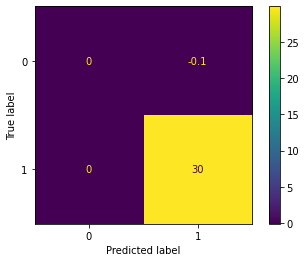

In [15]:
# benefit_matrix
ConfusionMatrixDisplay(confusion_matrix=np.array([[0, -0.10], [0, 29.90]])).plot()

In [16]:
def calculate_expected_profit(cm, bm):
    tn, fp, fn, tp = cm.ravel()
    b_tn, b_fp, b_fn, b_tp = bm.ravel()

    total_samples = np.sum(cm.ravel())

    p_pos = (tp + fn) / total_samples
    p_neg = (tn + fp) / total_samples

    p_tp = tp / (tp + fn)
    p_tn = tn / (tn + fp)
    p_fp = 1 - p_tn
    p_fn = 1 - p_tp

    pos_term = p_pos * (p_tp * b_tp + p_fn * b_fn)
    neg_term = p_neg * (p_tn * b_tn + p_fp * b_fp)

    expected_profit = pos_term + neg_term

    return expected_profit


benefit_matrix = np.array([[0, -0.10], [0, 29.90]])

default_profit = round(calculate_expected_profit(default_cm, benefit_matrix), 2)
weighted_profit = round(calculate_expected_profit(weighted_cm, benefit_matrix), 2)

print("Default Profit: {}\nWeighted Profit: {}".format(default_profit, weighted_profit))

Default Profit: 1.16
Weighted Profit: 2.55
